
📊 Performance Metrics:
   ➤ Accuracy : 92.00%
   ➤ Precision: 100.00%
   ➤ Recall   : 80.00%
   ➤ F1-Score : 88.89%


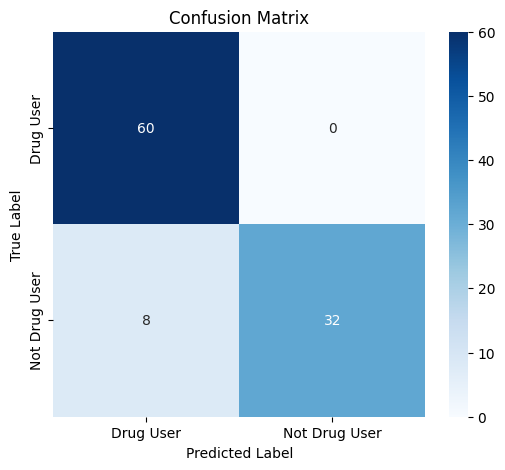

✅ Confusion matrix saved as confusion_matrix.png


<Figure size 640x480 with 0 Axes>

In [5]:
import torch
import torch.nn.functional as F
from torchvision import transforms, datasets
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ======================
# SETTINGS
# ======================
MODEL_PATH = "best_model.pth"
DEVICE = "cpu"  # change to "cuda" if GPU available
CLASS_NAMES = ["Drug User", "Not Drug User"]
BATCH_SIZE = 16
DATA_DIR = "data/drug_users_test"  # folder containing subfolders for each class

# ======================
# LOAD MODEL
# ======================
def load_model(model_path, device):
    checkpoint = torch.load(model_path, map_location=device)
    
    # Use weights=None instead of deprecated pretrained argument
    model = efficientnet_b0(weights=None)
    model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)
    
    # Remove "module." prefix if trained with DataParallel
    new_state_dict = {k.replace("module.", "") if k.startswith("module.") else k: v for k, v in checkpoint.items()}
    model.load_state_dict(new_state_dict)
    
    model.to(device)
    model.eval()
    return model

# ======================
# DATA LOADER
# ======================
def get_dataloader(data_dir, batch_size):
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader, dataset.classes

# ======================
# EVALUATE MODEL
# ======================
def evaluate(model, dataloader, device):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(probs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    acc = accuracy_score(all_labels, all_preds)
    prec = precision_score(all_labels, all_preds)
    rec = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print("\n📊 Performance Metrics:")
    print(f"   ➤ Accuracy : {acc * 100:.2f}%")
    print(f"   ➤ Precision: {prec * 100:.2f}%")
    print(f"   ➤ Recall   : {rec * 100:.2f}%")
    print(f"   ➤ F1-Score : {f1 * 100:.2f}%")

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Optional: Save confusion matrix as PNG
    plt.savefig("confusion_matrix.png", bbox_inches='tight')
    print("✅ Confusion matrix saved as confusion_matrix.png")

# ======================
# MAIN
# ======================
if __name__ == "__main__":
    model = load_model(MODEL_PATH, DEVICE)
    dataloader, classes = get_dataloader(DATA_DIR, BATCH_SIZE)
    evaluate(model, dataloader, DEVICE)
